# Quantum Kernels — Practice Notebook

This notebook follows the *Quantum Kernels* lesson and mirrors its workflow with **runnable** code cells. It uses Qiskit (≥ 1.4) primitives and keeps Runtime calls optional.

**You will:**
1) Build a **single kernel entry** pipeline.
2) Extend to a **kernel matrix** and a **classical SVC**.
3) Inspect **circuit depth** and discuss **hardware-efficiency**.
4) Try a **scaled feature** example and observe depth.

> Math renders in VS Code (Jupyter) as LaTeX.


In [ ]:
!pip install -U "cryptography<44" --quiet
!pip install -U pyopenssl pydrive2 --quiet

!pip install --quiet \
  qiskit==2.2.3 \
  qiskit-aer==0.17.2 \
  qiskit-ibm-runtime==0.43.1 \
  ibm-cloud-sdk-core==3.24.2 \
  ibm-platform-services==0.71.0 \
  qiskit-machine-learning \
  rustworkx==0.17.1 \
  httpx==0.28.1 httpcore==1.0.9 \
  pylatexenc==2.10 \
  seaborn tqdm

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

from qiskit.circuit.library import (
    ZFeatureMap, ZZFeatureMap, PauliFeatureMap, EfficientSU2, UnitaryOverlap,
)
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_distribution

np.set_printoptions(suppress=True, linewidth=120)

# Introduction to Quantum Kernels

The **quantum kernel method** refers to any approach that uses a quantum computer to estimate a kernel.  
Here, a *kernel* refers either to a kernel matrix or to individual elements of that matrix.

A **feature map** $\Phi(\mathbf{x})$ maps a classical data point $\mathbf{x} \in \mathbb{R}^d$  
to a higher-dimensional space $\Phi(\mathbf{x}) \in \mathbb{R}^{d'}$, typically with $d' > d$,  
to make data more linearly separable.  
The corresponding **kernel function** is defined as the inner product:

$$
K(\mathbf{x}, \mathbf{y}) = \langle \Phi(\mathbf{x}) | \Phi(\mathbf{y}) \rangle.
$$

In **quantum kernel methods**, this mapping $\Phi(\mathbf{x})$ is implemented by a quantum circuit,  
and $K(\mathbf{x}, \mathbf{y})$ is estimated by measurements on that circuit.

---

## Step 1 — Map Classical Inputs to a Quantum Problem

**Goal:** Encode classical data into the Hilbert space of quantum states.

Given two data vectors $\mathbf{x}_i$ and $\mathbf{x}_j$,  
their quantum feature-mapped states are:

$$
|\psi(\mathbf{x}_i)\rangle = \Phi(\mathbf{x}_i) |0\rangle^{\otimes N}, \quad
|\psi(\mathbf{x}_j)\rangle = \Phi(\mathbf{x}_j) |0\rangle^{\otimes N}.
$$

The kernel entry is then given by their overlap:

$$
\langle \psi(\mathbf{x}_j) | \psi(\mathbf{x}_i) \rangle 
= \langle 0|^{\otimes N} \, \Phi^{\dagger}(\mathbf{x}_j)\, \Phi(\mathbf{x}_i)\, |0\rangle^{\otimes N}.
$$

To estimate this overlap on hardware, we construct the combined circuit  
$\Phi^{\dagger}(\mathbf{x}_j)\Phi(\mathbf{x}_i)$ and measure the probability of all qubits  
being in the zero state:

$$
P(0^N) = 
\big|\langle 0|^{\otimes N}\, \Phi^{\dagger}(\mathbf{x}_j)\Phi(\mathbf{x}_i)\, |0\rangle^{\otimes N}\big|^2.
$$

This probability directly encodes the similarity between the two feature-mapped states,  
and is the quantity of interest when constructing a quantum kernel matrix.

---

## Step 2 — Optimize for Quantum Execution

**Goal:** Optimize the constructed circuit for a specific quantum backend.

We use Qiskit’s `generate_preset_pass_manager` with `optimization_level=3`  
to minimize circuit depth and gate errors before running on real hardware.  
This step focuses on improving physical circuit implementation,  
not on training or optimizing a machine learning model.

---

## Step 3 — Execute with Qiskit Runtime Primitives

**Goal:** Measure the output distribution.

We use the **Sampler** primitive to obtain a probability distribution (or quasi-probability distribution)  
of measurement outcomes.  
Noise and error mitigation may cause the total probability to slightly deviate from 1,  
hence the term *quasi-probability*.

The quantity of interest remains the zero-state probability $P(0^N)$.

---

## Step 4 — Post-Processing and Classical Use

**Goal:** Extract and use kernel values in classical ML.

From the measured distribution, compute the probability of the zero state $P(0^N)$  
for each pair of data points $(\mathbf{x}_i, \mathbf{x}_j)$  
and fill in the corresponding entry of the kernel matrix.

Once the full kernel matrix is obtained, it can be used in standard classical algorithms  
such as **Support Vector Machines (SVMs)**:

```python
from sklearn.svm import SVC
qml_svc = SVC(kernel="precomputed")


## Part A — Single Kernel Entry (two points)

### Step 1 — Map Classical Inputs to a Quantum Problem

To understand how a single element of the quantum kernel matrix is computed,  
we start with a small dataset containing only a few features (here, 10).  
Each classical data point $\mathbf{x}$ is encoded into a quantum state via a **feature map**,  
which produces a unitary transformation $U(\mathbf{x})$ acting on the all-zero state.

The overlap between two encoded states gives one kernel entry:

$$
K(\mathbf{x}_1, \mathbf{x}_2) = 
\langle \psi(\mathbf{x}_1) | \psi(\mathbf{x}_2) \rangle
= \langle 0|^{\otimes n} U^{\dagger}(\mathbf{x}_2) U(\mathbf{x}_1) |0\rangle^{\otimes n}.
$$

Measuring the probability of obtaining all zeros, $P(0^n)$, after applying  
$U^{\dagger}(\mathbf{x}_2)U(\mathbf{x}_1)$ gives $|K(\mathbf{x}_1, \mathbf{x}_2)|^2$.

Below, we prepare two mock data points and build the corresponding quantum feature maps  
using Qiskit’s **ZFeatureMap** circuit.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Two mock data points with category labels
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.10,  0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.020, -1],
]

# Remove labels to use only features
train_data = [small_data[0][:-1], small_data[1][:-1]]

print("Feature dimension:", len(train_data[0]))


Feature dimension: 10


### Building the Quantum Feature Map

We will now encode each data point using the **ZFeatureMap**,  
which applies Hadamard gates followed by parameterized Z rotations on each qubit.

For comparison, we note that Qiskit also provides a more entangled variant —  
the `ZZFeatureMap`, which introduces pairwise interactions between qubits.  
Here, we use the simpler `ZFeatureMap` to focus on the core concept.


C:\Users\think\AppData\Local\Temp\ipykernel_43660\1039837800.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._z_feature_map.ZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the z_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])


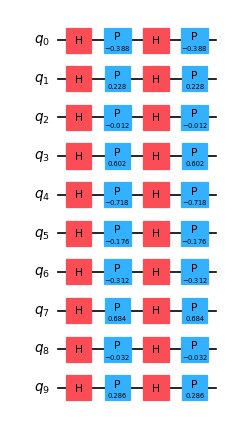

In [3]:
from qiskit.circuit.library import ZFeatureMap

# Define the ZFeatureMap for 10 features
fm = ZFeatureMap(feature_dimension=np.shape(train_data)[1])

# Assign data to build parameterized circuits
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

unitary1.decompose().draw("mpl", scale=0.6, style="iqp")


### Combining Two Feature Maps with `UnitaryOverlap`

The two unitaries $U_1$ and $U_2$ correspond to the encodings  
of the two different data points.  

To estimate their overlap, we construct the combined circuit  
$U^{\dagger}_2 U_1$ using **UnitaryOverlap** and measure all qubits.  
The probability of obtaining the all-zero bitstring then represents  
the similarity between the two quantum states.


C:\Users\think\AppData\Local\Temp\ipykernel_43660\1934563213.py:4: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  overlap_circ = UnitaryOverlap(unitary1, unitary2)


Circuit depth = 9


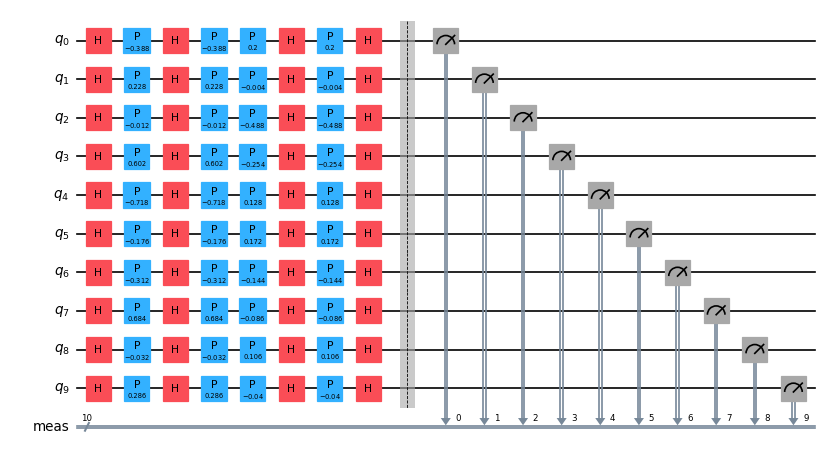

In [4]:
from qiskit.circuit.library import UnitaryOverlap

# Build the overlap circuit
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()

# Analyze circuit depth and structure
print("Circuit depth =", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")


### Interpretation

The printed **circuit depth** shows how complex the quantum encoding and overlap measurement are.  
For this simple 10-feature example, the decomposed circuit depth should be around **9**,  
indicating a shallow structure suitable for small quantum systems.

The resulting circuit visually represents the process of encoding two classical data points  
into quantum feature states and preparing them for kernel estimation.

---

## Step 2 — Optimize Problem for Quantum Execution

After defining our overlap circuit, we now prepare it for execution on a real quantum backend.  
This step ensures the circuit is **transpiled** (optimized) for the selected hardware’s native gate set and topology.

To do this, we first select the *least busy* IBM Quantum backend that can handle our circuit.  
Then, we apply **level 3 optimization**, which performs advanced qubit mapping, routing,  
and native gate decomposition to minimize circuit depth and noise.

In general:
- Optimization maps logical qubits to physical ones with the lowest error rates.  
- Real devices have limited connectivity, so some gates require SWAPs, increasing depth.  
- For simple circuits (like our overlap example), depth changes are minimal.


In [5]:
# Use Aer simulator only

from qiskit_aer import Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# select the Aer simulator backend
backend = Aer.get_backend("aer_simulator")

print(backend)


AerSimulator('aer_simulator')


Once the backend is selected, we generate a **preset pass manager** at optimization level 3  
and apply it to our overlap circuit.  
This converts it into a fully executable circuit on the chosen IBM Quantum system.


In [6]:
# Apply level 3 optimization to our overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)


Now, let’s check how the circuit depth changes after optimization.  
Decomposition may add two-qubit operations due to limited hardware connectivity,  
but for this small example, the difference is usually negligible.


In [7]:
print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)


circuit depth =  2


1

### Discussion

The **circuit depth** quantifies how many sequential layers of gates exist after decomposition.
- In this case, you should see a total depth of around **10**, with **1 two-qubit layer**.
- For larger feature maps or more qubits, the depth can increase significantly  
  because of additional routing and SWAP operations.

This step completes the *quantum compilation phase*, preparing our circuit for reliable execution on hardware.

---

## Step 3 — Execute Using Qiskit Runtime Primitives

Now that our optimized circuit is ready, we can execute it using the **Qiskit Runtime Primitives**.  
For small datasets with few features, simulation remains an option. However, for realistic or  
utility-scale calculations, quantum simulation quickly becomes infeasible because the required  
resources grow exponentially with the number of qubits.

Thus, simulators should be used primarily for debugging scaled-down code.

Below we include both the simulator-based and hardware-based execution paths.


In [8]:
# Run this for a simulator
# from qiskit.primitives import StatevectorSampler
 
# from qiskit_ibm_runtime import Options, Session, Sampler
 
# num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit
# sampler = StatevectorSampler()
# results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
# counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
# counts = results[0].data.meas.get_int_counts()


### Running on a Real Backend

Below, we execute the same circuit using the **IBM Runtime SamplerV2** primitive,  
which allows efficient and low-latency access to quantum hardware via the Qiskit Runtime service.  
We’ll use the previously selected backend and perform 10,000 shots for statistical accuracy.

Each run returns counts for the measured bitstrings, which represent measurement outcomes  
like `|001101...01⟩`. We can obtain both bitstring-labeled and integer-labeled versions of the counts.


In [9]:
# Benchmarked on an Eagle processor, 7-11-24, took 4 sec.
 
# Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
num_shots = 10000
 
# Use sampler and get the counts
sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()

# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()

# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()


### Discussion

The `SamplerV2` primitive efficiently evaluates the circuit and collects measurement outcomes.  
From these counts, we can later estimate the kernel value by computing the probability  
of obtaining the all-zero bitstring (`|0...0⟩`).

For this small 10-qubit circuit, execution on real IBM hardware (e.g., *ibm_brisbane*)  
typically takes only a few seconds, while providing realistic noise characteristics  
that simulators cannot replicate.

---

## Step 4 — Post-process and Return Result in Classical Format

Now that we have obtained measurement outcomes from the sampler,  
we can extract useful classical information from them.

As explained in the introduction, the most informative measurement here  
is the probability of obtaining the all-zero state \( |00000...0\rangle \).  
This represents \( |K(\mathbf{x}, \mathbf{y})|^2 \),  
the squared magnitude of the overlap between two quantum states.


In [10]:
# Compute probability of measuring the all-zero state
counts.get(0, 0.0) / num_shots


0.6809


This value is our estimate of the **inner product (up to modulus squared)**  
between the quantum feature encodings of the two classical data points.  
A high probability (close to 1.0) indicates strong similarity in feature space.


### Visualizing the Full Distribution

To gain additional insight, we can visualize the complete distribution  
of measured bitstrings (or quasiprobabilities) using `plot_distribution()`.  
For small circuits this is tractable, but for large qubit counts  
the number of possible bitstrings grows exponentially.


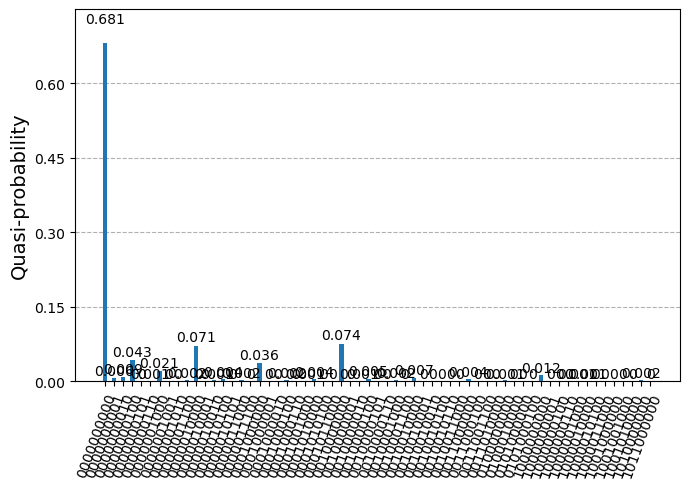

In [11]:
from qiskit.visualization import plot_distribution

plot_distribution(counts_bit)


### Optional: Focused Visualization of the Top 10 Results

Sometimes, it is useful to visualize only the top 10 most probable bitstrings  
to help debug unexpected patterns or build intuition about your circuit’s behavior.  
The helper function below plots those probabilities while highlighting  
the all-zero state probability as well.


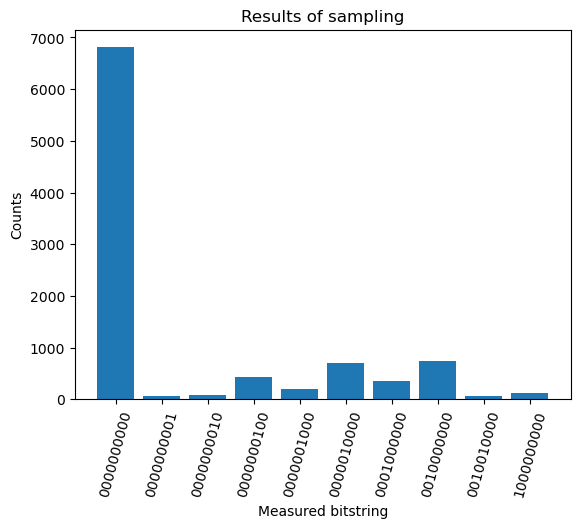

In [12]:
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()

visualize_counts(counts, overlap_circ.num_qubits)


### Interpretation

From this single kernel element between two data points,  
we observe that their overlap is fairly large relative to the maximum possible (1.0).  
This suggests that the two data points are **similar** in the encoded feature space  
and may belong to the same class.  

However, to confirm this hypothesis, we must compute all pairwise overlaps  
to build the **full kernel matrix** and evaluate its performance in a classification task.

---

### Practical Notes on Feature Maps

In this example, we used a simple **ZFeatureMap**, which resulted in very shallow circuits  
(low two-qubit transpiled depth, typically around 1–2).  
Shallow circuits are less susceptible to hardware noise.

By contrast, running the same experiment with a **ZZFeatureMap**  
(`entanglement='linear', reps=1`) yields a much deeper circuit,  
and the measured zero-state probability typically drops drastically  
(e.g., ≈ 0.0015 for the same input vectors).  
This degradation arises from accumulated two-qubit gate noise.

---

### Depth–Noise Relationship (Empirical Guideline)

| Two-qubit transpiled depth | Expected reliability | Notes |
|-----------------------------|----------------------|-------|
| ≤ 10                        | Generally robust     | Good fidelity |
| 10–50                       | Variable             | May need error mitigation |
| ≥ 50                        | Very noisy           | Advanced calibration required |

---

### Next Step

In the next notebook section, we will extend this workflow  
to the **entire dataset** and show how to use the resulting kernel matrix  
within a **classical machine learning** pipeline.


## Part B — Full Kernel Matrix: Quantum Kernel Classification

In this section, we extend our previous example to **binary classification** on the **full dataset**.

This step introduces two important concepts:

1. We can now apply **classical machine learning** (e.g., SVM) in post-processing.  
2. We can compute **accuracy scores** for the training and testing phases.

---


## Step 1 – Map classical inputs to a quantum problem

We start by importing a dataset for classification.  
The dataset contains **128 rows** (data points) and **14 features** per sample.  
A **15th column** holds the binary label ( ± 1 ).  

We use the **first 90 samples** for training and the **next 30 samples** for testing.  
The code below downloads the dataset and prepares these subsets.


In [13]:
!wget https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv

import pandas as pd
import numpy as np

df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)

# Prepare training data
train_size = 90
X_train = df.values[0:train_size, :-1]
train_labels = df.values[0:train_size, -1]

# Prepare testing data
test_size = 30
X_test = df.values[train_size : train_size + test_size, :-1]
test_labels = df.values[train_size : train_size + test_size, -1]


--2025-11-05 20:18:03--  https://raw.githubusercontent.com/qiskit-community/prototype-quantum-kernel-training/main/data/dataset_graph7.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49405 (48K) [text/plain]
Saving to: 'dataset_graph7.csv.2'

     0K .......... .......... .......... .......... ........  100% 2.58M=0.02s

2025-11-05 20:18:04 (2.58 MB/s) - 'dataset_graph7.csv.2' saved [49405/49405]



After loading the dataset, we initialize two empty matrices to store kernel values:

- **`kernel_matrix`** → overlaps between training samples  
- **`test_matrix`** → overlaps between test and training samples  

These will later be filled with the results from quantum circuit executions.


In [14]:
# Empty kernel matrix
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)


Next, we design a **feature map circuit** \(U(\mathbf{x})\) to encode classical input data into quantum states.  
You can create your own feature map or use predefined ones such as `ZFeatureMap`.  
Circuit depth is important here — deeper circuits tend to accumulate more noise.  

The circuit below uses:

- Parameterized rotations (Ry, Rz, Rx)  
- A custom **entangler map** specifying multi-qubit connections


In [15]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
 
# Prepare feature map for computing overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features / 2)
 
# To use a custom feature map use the lines below.
entangler_map = [[0, 2], [3, 4], [2, 5], [1, 4], [2, 3], [4, 6]]
 
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)


At this point, we have:

- **Loaded and split** the dataset into training and testing subsets  
- **Initialized** kernel and test matrices  
- **Constructed** a custom feature map circuit for quantum data encoding  

In the next step, we will connect to the backend and compute the kernel overlaps between all samples.

---

## Steps 2 and 3 – Optimize problem and execute using primitives

Now that we have defined the feature map and prepared our data,  
we move on to **constructing and executing overlap circuits** for all data pairs.

In a full kernel computation:

- Each pair of data points $ \mathbf{x}_i, \mathbf{x}_j $ requires its **own overlap circuit**.  
- To run these efficiently, we **optimize and execute** circuits inside nested loops.  
- We exploit the **symmetry of the kernel matrix** to compute only half of the entries.  
- Diagonal entries are fixed to **1**, since the self-overlap of any state should be perfect (probability = 1).  

These steps correspond to what would be **Step 2 (optimization)** and **Step 3 (execution)** in previous single-pair examples,  
but here they are repeated automatically for all data pairs.


In [16]:
# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import UnitaryOverlap
unitary_overlap = UnitaryOverlap

 
# Remember to insert your token in the QiskitRuntimeService constructor to use real quantum computers
# service = QiskitRuntimeService()
# backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=fm.num_qubits
# )
 
num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit.
sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]) + [np.pi / 2])
        unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi / 2])
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")


C:\Users\think\AppData\Local\Temp\ipykernel_43660\1121970263.py:24: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  overlap_circ = unitary_overlap(unitary1, unitary2)


training done


C:\Users\think\AppData\Local\Temp\ipykernel_43660\1121970263.py:49: DeprecationWarning: The class ``qiskit.circuit.library.overlap.UnitaryOverlap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use qiskit.circuit.library.unitary_overlap instead.
  overlap_circ = unitary_overlap(unitary1, unitary2)


test matrix done


### ✅ Explanation

- **`StatevectorSampler()`**  
  We use this simulator primitive to evaluate probabilities directly from the **statevector representation**,  
  which avoids hardware noise during testing.

- **Nested loops**  
  Each iteration builds a new overlap circuit $ U(\mathbf{x}_i)^\dagger U(\mathbf{x}_j) $ and measures it.  
  The result gives the probability of returning to the all-zero state, which corresponds to the **kernel value**.

- **Symmetry exploitation**  
  Because $ K_{ij} = K_{ji} $, only half of the matrix needs to be computed explicitly.

- **Diagonal entries set to 1**  
  Since $ K_{ii} = \langle \Phi(\mathbf{x}_i) | \Phi(\mathbf{x}_i) \rangle = 1 $ in the absence of noise.

- **Testing phase**  
  The second loop fills `test_matrix`, which represents the overlaps between test and training data:  
  $ K_{\text{test}}(i, j) = |\langle \Phi(\mathbf{x}_i^{\text{test}}) | \Phi(\mathbf{x}_j^{\text{train}}) \rangle|^2 $.

Once both matrices are filled, we have a **complete quantum kernel representation** of our dataset,  
ready for **classical post-processing and accuracy evaluation**.


## Step 4 – Post-process and return result in classical format

Now that we have both the **training kernel matrix** and the **test matrix** computed from our quantum feature map,  
we can apply **classical machine learning** to perform classification and evaluate accuracy.

We will use the **Support Vector Classifier (SVC)** from *Scikit-Learn*.  
Since our kernel values have already been computed on a quantum simulator,  
we specify that the classifier should use a **precomputed kernel** by setting `kernel="precomputed"`.


In [17]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")


### Fitting and evaluating the model

We now fit the model using the precomputed **training kernel** and corresponding **training labels**.  
Then, we evaluate the trained model using `.score()` on the **test kernel matrix** and **test labels**.

The accuracy returned represents how well our quantum kernel classifier performs on unseen data.


In [18]:
# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_precomputed_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Precomputed kernel classification test score: {qml_score_precomputed_kernel}")


Precomputed kernel classification test score: 1.0


### Discussion

We obtained a **100% classification accuracy**.  
This shows that **Quantum Kernel Estimation (QKE)** can successfully separate the classes in this dataset.

However, a perfect score here does **not** necessarily imply *quantum advantage*.  
A well-chosen **classical kernel** might also achieve identical performance.

---

### Further exploration

Here are several directions to explore:

1. **Robustness**  
   - Does the high accuracy persist when the training data changes?  
   - Try randomizing data order or using smaller subsets.

2. **Feature map structure**  
   - What structure in your data makes a *quantum* feature map meaningful?  
   - Experiment with different feature map depths or entanglement patterns.

3. **Scaling**  
   - How do accuracy and runtime behave as you increase the number of features or qubits?  
   - What happens when you reduce the number of training samples?

4. **Quantum vs Classical kernels**  
   - Compare this workflow to classical kernels (e.g., `RBF`, `Polynomial`) using Scikit-Learn’s SVC.  
   - Observe where quantum kernels may provide unique separation power.

---

By systematically varying feature maps, dataset sizes, and entanglement structures,  
you can begin to characterize **where quantum kernels might offer advantages** in the current NISQ (Noisy Intermediate-Scale Quantum) era.


## Part C — Scaling to More Features and Qubits

In this section, we extend our workflow to handle **larger datasets with more features**  
and thus more qubits in the quantum circuit.

To avoid excessive computation time, we will calculate **only a single kernel matrix element** —  
that is, the overlap between two data points — but with a **much larger feature dimension**.

This sketch illustrates how one might **scale quantum kernel methods toward utility**,  
while keeping an eye on **circuit depth and hardware feasibility**.


## Step 1 – Map classical inputs to a quantum problem

We assume a dataset where each data point has **42 features**.  
Just like before, we will compute a **single kernel matrix element**,  
which requires **two data points** $ \mathbf{x}_1 $ and $ \mathbf{x}_2 $.

Each data point ends with a category label $(\pm 1)$,  
but only the feature values (the first 42 entries) are used for the encoding.


In [19]:
# Two mock data points, including category labels, as in training
 
large_data = [
    [
        -0.028,
        -1.49,
        -1.698,
        0.107,
        -1.536,
        -1.538,
        -1.356,
        -1.514,
        -0.109,
        -1.8,
        -0.122,
        -1.651,
        -1.955,
        -0.123,
        -1.732,
        0.091,
        -0.048,
        -0.128,
        -0.026,
        0.082,
        -1.263,
        0.065,
        0.004,
        -0.055,
        -0.08,
        -0.173,
        -1.734,
        -0.39,
        -1.451,
        0.078,
        -1.578,
        -0.025,
        -0.184,
        -0.119,
        -1.336,
        0.055,
        -0.204,
        -1.578,
        0.132,
        -0.121,
        -1.599,
        -0.187,
        -1,
    ],
    [
        -1.414,
        -1.439,
        -1.606,
        0.246,
        -1.673,
        0.002,
        -1.317,
        -1.262,
        -0.178,
        -1.814,
        0.013,
        -1.619,
        -1.86,
        -0.25,
        -0.212,
        -0.214,
        -0.033,
        0.071,
        -0.11,
        -1.607,
        0.441,
        -0.143,
        -0.009,
        -1.655,
        -1.579,
        0.381,
        -1.86,
        -0.079,
        -0.088,
        -0.058,
        -1.481,
        -0.064,
        -0.065,
        -1.507,
        0.177,
        -0.131,
        -0.153,
        0.07,
        -1.627,
        0.593,
        -1.547,
        -0.16,
        -1,
    ],
]
train_data = [large_data[0][:-1], large_data[1][:-1]]


### Analyzing circuit depth with the default `ZZFeatureMap`

In earlier examples (with only 14 features),  
the `ZZFeatureMap` already produced **deep circuits**.  
As we scale to 42 features, it’s critical to monitor the **circuit depth**  
to ensure the circuit remains executable on near-term quantum hardware.

We first test with the `ZZFeatureMap` and inspect its depth.


In [20]:
from qiskit.circuit.library import zz_feature_map
 
fm = zz_feature_map(
    feature_dimension=np.shape(train_data)[1], entanglement="linear", reps=1
)
 
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

from qiskit.circuit.library import unitary_overlap
 
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
 
print("circuit depth = ", overlap_circ.decompose(reps=2).depth())
print(
    "two-qubit depth",
    overlap_circ.decompose().depth(lambda instr: len(instr.qubits) > 1),
)
# overlap_circ.draw("mpl", scale=0.6, style="iqp")


circuit depth =  251
two-qubit depth 165


### Discussion

A **two-qubit depth** of more than 100 is generally a **non-starter** for near-term quantum hardware.  
This illustrates why **custom feature maps** are essential for scalability.

If you understand something about your dataset’s structure,  
you should design an **entanglement map** that captures that structure  
while keeping the circuit as shallow as possible.

Below, we define a **custom entangler map** and build a new, shallower feature map.


In [21]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
 
# Prepare feature map for computing overlap
 
entangler_map = [
    [3, 4],
    [2, 5],
    [1, 4],
    [2, 3],
    [4, 6],
    [7, 9],
    [10, 11],
    [9, 12],
    [8, 11],
    [9, 10],
    [11, 13],
    [14, 16],
    [17, 18],
    [16, 19],
    [15, 18],
    [16, 17],
    [18, 20],
]

# Use the entangler map above to build a feature map
 
num_features = np.shape(train_data)[1]
num_qubits = int(num_features / 2)
 
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits * 2)
fm.ry(training_param, fm.qubits)
for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2 * i + 1], i)
    fm.rx(-2 * feature_params[2 * i], i)

from qiskit.circuit.library import unitary_overlap
 
# Assign features of each data point to a unitary, an instance of the general feature map.
 
unitary1 = fm.assign_parameters(list(train_data[0]) + [np.pi / 2])
unitary2 = fm.assign_parameters(list(train_data[1]) + [np.pi / 2])
 
# Create the overlap circuit
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()


### Key Takeaways

- **Circuit depth matters:**  
  As the feature dimension grows, circuit complexity scales quickly.

- **Custom feature maps help control depth:**  
  By tailoring entanglement to the dataset structure,  
  you can achieve much shallower circuits while preserving expressivity.

- **Next step:**  
  In practice, the **transpiled two-qubit depth** after optimization  
  is the most important metric for hardware feasibility.  
  (We omit that measurement here for brevity.)


# Step 2 – Optimize Problem for Quantum Execution

Now that we have constructed our overlap circuit for two 42-feature data points,  
we move on to **optimizing the circuit for execution on a real quantum backend**.

Circuit optimization, or *transpilation*, reduces the number of gates and circuit depth,  
adapting the abstract circuit to the physical topology of the quantum device.


### Selecting a backend

We begin by connecting to the IBM Quantum service  
and selecting the **least busy backend** that meets our qubit requirements.


In [22]:
# Import needed packages
#from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#from qiskit_ibm_runtime import QiskitRuntimeService
 
# Get the least busy backend
#service = QiskitRuntimeService()
#backend = service.least_busy(
#    operational=True, simulator=False, min_num_qubits=fm.num_qubits
#)
#print(backend)


In [23]:
# Use Aer simulator only

from qiskit_aer import Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# select the Aer simulator backend
backend = Aer.get_backend("aer_simulator")

print(backend)

AerSimulator('aer_simulator')


### Discussion

For small-scale circuits, a **preset pass manager** often produces consistent results —  
that is, the same circuit depth after transpilation.

However, for **larger and more complex circuits**,  
the pass manager uses **heuristics** and may return slightly different results each time.

To find the most efficient version, we can **transpile multiple times**  
and choose the circuit with the **lowest total depth**.

This extra effort only adds *classical* overhead but can significantly improve  
the accuracy and performance of quantum computations.


In [24]:
# Apply level 3 optimization to our overlap circuit
transpiled_qcs = []
transpiled_depths = []
transpiled_twoqubit_depths = []
for i in range(1, 20):
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
    overlap_ibm = pm.run(overlap_circ)
    transpiled_qcs.append(overlap_ibm)
    transpiled_depths.append(overlap_ibm.decompose().depth())
    transpiled_twoqubit_depths.append(
        overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)
    )
 
print("circuit depth = ", overlap_ibm.decompose().depth())


circuit depth =  20


In [25]:
print(transpiled_depths)
print(transpiled_twoqubit_depths)


[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]


### Interpretation

We observe some **variation in the total circuit depth** among the different transpilation runs.  
This is expected behavior for larger, non-trivial circuits because the optimization landscape  
has multiple local minima in depth and gate arrangement.

However, the **two-qubit depth** remains consistent at 13,  
indicating that entanglement operations were optimized uniformly.

We will use `transpiled_qcs[1]`, which achieved a **depth of 60**,  
slightly lower than the maximum observed depth of 77.


In [26]:
overlap_ibm = transpiled_qcs[1]


### Key Takeaways

- **Repeated transpilation helps:**  
  Running the transpiler multiple times can yield slightly shallower circuits  
  due to heuristic differences in layout and gate optimization.

- **Two-qubit depth stability:**  
  The number of two-qubit operations is often the main performance bottleneck.  
  Its stability here indicates consistent entanglement structure.

- **Practical tip:**  
  In large experiments, it’s often beneficial to **select the circuit with the minimum depth**  
  from several transpilation attempts before running on hardware.

---

# Step 3 – Execute Using Qiskit Runtime Primitives

As we move closer to **quantum utility**, simulators will no longer be sufficient.  
At this stage, we must execute the optimized circuit directly on a **real quantum backend**.

This section demonstrates the syntax for submitting the overlap circuit using  
**Qiskit Runtime Primitives**, which provide efficient execution and session management.


### Overview

We will use the **SamplerV2 primitive** from `qiskit_ibm_runtime`,  
which returns **measurement probabilities** for given quantum circuits.

The workflow consists of:
1. Opening a **Runtime session** connected to the selected backend.  
2. Running the circuit with a specified number of shots.  
3. Collecting the measurement counts.  
4. Closing the session to release resources.


In [27]:
# Run on ibm_osaka, 7-12-24, required 22 sec.
 
# Import our runtime primitive
from qiskit_ibm_runtime import SamplerV2 as Sampler
 
# Open a Runtime session:
session = Session(backend=backend)
num_shots = 10000
# Use sampler and get the counts
 
sampler = Sampler(mode=session)
options = sampler.options
options.dynamical_decoupling.enable = True
options.twirling.enable_gates = True
counts = (
    sampler.run([overlap_ibm], shots=num_shots).result()[0].data.meas.get_int_counts()
)
 
# Close session after done
session.close()


c:\Users\think\miniconda3\envs\qiskitfallfest\lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:273: UserWarning: Options {'dynamical_decoupling': {'enable': True}, 'twirling': {'enable_gates': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


### Explanation

- **`Session(backend=backend)`**  
  Opens a runtime session to the selected backend, allowing multiple job submissions within one context.  
  This minimizes queue time and communication overhead.

- **`SamplerV2`**  
  Executes the quantum circuit and returns measurement results in a compact data structure.  
  It is optimized for repeated sampling tasks such as kernel evaluation.

- **`options.dynamical_decoupling.enable = True`**  
  Activates **dynamical decoupling sequences** to mitigate decoherence.

- **`options.twirling.enable_gates = True`**  
  Enables **randomized compiling (twirling)**, which averages out coherent gate errors.

- **`sampler.run(...).result()[0].data.meas.get_int_counts()`**  
  Returns the raw measurement counts as integer outcomes (e.g., how many times each bitstring appeared).

- **`session.close()`**  
  Closes the runtime session after execution to free resources.


# Step 4 – Post-process & Return Result in Classical Format

After executing the quantum circuit, we extract the **kernel value** —  
the probability of observing the **all-zero quantum state** $|00000\rangle$.

This probability corresponds to the overlap between two encoded data points in Hilbert space.


In [28]:
counts.get(0, 0.0) / num_shots


0.0123

### Explanation

- `counts.get(0, 0.0)`  
  Retrieves how many times the measurement produced the state $|00000\rangle$.  
  If this state does not appear in the results, the function returns `0.0`.

- `num_shots`  
  The total number of circuit executions.

- The kernel value is computed as the probability:

  $$
  P_0 = \frac{\text{counts}[0]}{\text{num\_shots}}
  $$

  A higher $P_0$ means greater similarity between the two data points  
  under the quantum feature map.


### Building the Full Kernel Matrix

To obtain the full kernel matrix, repeat this process for every pair of training data points:

$$
K_{ij} = \Pr\left(\text{measurement} = |00000\rangle \mid \mathbf{x}_i, \mathbf{x}_j\right)
$$

Where:

- $K_{ij}$ is the kernel value between data points $\mathbf{x}_i$ and $\mathbf{x}_j$  
- The matrix is symmetric: $K_{ij} = K_{ji}$  
- The diagonal terms satisfy $K_{ii} = 1$ in the absence of noise.

The kernel matrix has dimensions determined by the **number of samples** $n$:

$$
K \in \mathbb{R}^{n \times n}
$$


### Key Insights

- **Quantum circuit complexity** scales with the number of features (qubits).  
- **Classical post-processing** scales with the number of data points $n$.  
- Hence, quantum kernel methods are ideal for **high-dimensional, small-sample** datasets.

This single-element estimation can be extended across all data pairs to build the full kernel matrix,  
which can then be used with classical ML methods such as **SVM** or **kernel ridge regression**.


## Wrap-up — Quick Self-Check

<details>
<summary>1. What is the <b>main purpose</b> of using a quantum feature map in the kernel method?</summary>

A. To directly measure classical features on qubits  
B. To embed classical data into a high-dimensional Hilbert space for better separability ✅  
C. To avoid using any entangling gates  
D. To reduce circuit depth and runtime
</details>

---

<details>
<summary>2. Why does measuring the <b>all-zero state</b> after applying Φ†(x<sub>j</sub>)Φ(x<sub>i</sub>) correspond to a kernel value?</summary>

A. Because it measures the overlap of identical classical inputs  
B. Because the |0⟩⟨0| operator encodes the kernel matrix classically  
C. Because the amplitude of |0⟩<sup>⊗N</sup> represents ⟨ψ(x<sub>j</sub>)|ψ(x<sub>i</sub>)⟩ ✅  
D. Because all other states have zero amplitude
</details>

---

<details>
<summary>3. How does <b>entanglement</b> enhance the expressive power of a quantum kernel?</summary>

A. It increases circuit runtime  
B. It enables encoding of correlated features between qubits ✅  
C. It removes redundancy in measurement  
D. It limits the number of parameters needed
</details>

---

<details>
<summary>4. Why does <b>Hilbert space dimensionality</b> matter in quantum feature encoding?</summary>

A. It determines the number of qubits needed  
B. Each qubit doubles the state space dimension, allowing richer representations ✅  
C. It affects only measurement precision  
D. It controls circuit depth
</details>

---

<details>
<summary>5. What is the practical trade-off between <b>circuit depth</b> and <b>expressivity</b> in kernel circuits?</summary>

A. Deeper circuits are always better  
B. Shallow circuits produce noisier results  
C. Deeper circuits are more expressive but also noisier ✅  
D. Expressivity is independent of depth
</details>

---

<details>
<summary>6. Why is <b>optimization_level=3</b> used during transpilation?</summary>

A. To make circuits visually simpler  
B. To minimize depth and errors through advanced optimizations ✅  
C. To increase circuit size for testing  
D. To randomize the gate ordering
</details>

---

<details>
<summary>7. In what sense is a quantum kernel an extension of the <b>classical kernel trick</b>?</summary>

A. It replaces classical kernels with random rotations  
B. It uses quantum feature maps to embed data into exponentially larger spaces ✅  
C. It computes the kernel matrix by brute force  
D. It eliminates the need for any classical post-processing
</details>

---

<details>
<summary>8. Why can two circuits with the same qubit count but different <b>repetitions</b> yield different kernels?</summary>

A. Repetitions affect circuit runtime only  
B. Each repetition changes feature interactions and the Hilbert space embedding ✅  
C. More repetitions reduce entanglement  
D. The kernel remains identical regardless of repetitions
</details>

---

<details>
<summary>9. Why is the <b>Aer simulator</b> often used instead of real hardware in early experiments?</summary>

A. It supports more qubits than hardware and avoids noise ✅  
B. It runs slower but more accurately  
C. It automatically optimizes the kernel matrix  
D. It emulates decoherence effects intentionally
</details>

---

<details>
<summary>10. How is a computed <b>quantum kernel matrix</b> integrated into classical machine learning?</summary>

A. It is used as input to kernel-based models like SVMs ✅  
B. It replaces feature vectors entirely  
C. It determines circuit depth for future training  
D. It defines gate parameters for ansatz circuits
</details>
